# Поиск нейронных архитектур

На лекции мы обсуждали основы поиска нейронных архитектур, а теперь попробуем самостоятельно реализовать некоторые подходы и посмотрим, какое влияние они оказывают на практике

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from time import time
from copy import deepcopy
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import torch.nn.utils.prune as prune


Для начала создадим простую нейронную сеть и подготовим данные для нее.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 13244590.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 374172.40it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3211948.95it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 12103258.43it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

image shape: torch.Size([512, 1, 28, 28]) 
 label shape: torch.Size([512])


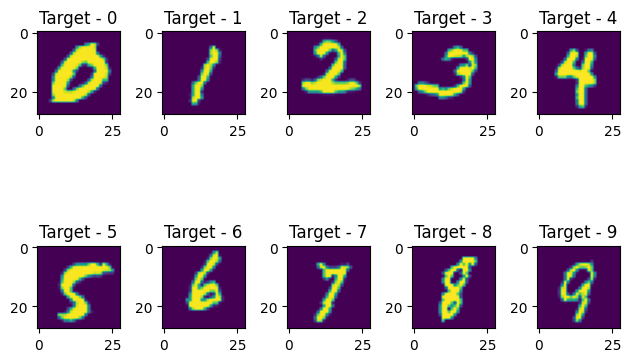

In [2]:
def load_MNIST():
    """Function to load and normalize MNIST data"""
    transform = transforms.Compose([
        transforms.RandomRotation(10),  # Rotate images by up to 10 degrees
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize the images
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load MNIST dataset
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

    # Data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)
    return train_dataset, test_dataset, train_loader, test_loader

def visualize_MNIST(train_loader):
    """Function to visualize data given a DataLoader object"""
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    print("image shape:", images.shape, "\n label shape:", labels.shape)
    # visualize data
    fig, ax = plt.subplots(2,5)
    for i, ax in enumerate(ax.flatten()):
        im_idx = np.argwhere(labels == i)[0][0]
        plottable_image = images[im_idx].squeeze()
        ax.imshow(plottable_image)
        ax.set_title(f"Target - {i}")
    plt.tight_layout()

# load and visualize MNISt
train, test, train_loader, test_loader = load_MNIST()
visualize_MNIST(train_loader)

In [35]:
def entropy_loss(model, mu=1e-3):
    d = model.get_alphas_train()
    res = 0
    for k in d:
        p = torch.softmax(d[k], dim=-1)
        ent = (p * torch.log(p + 1e-7)).sum()
        res += ent
    return mu * res


def train_epoch(model, device, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data, target in tqdm(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss += entropy_loss(model)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy


def evaluate(model, device, dataloader):
    model.eval()
    correct = 0
    total = 0
    total_time = 0
    with torch.no_grad():
        for data, target in tqdm(dataloader):
            data, target = data.to(device), target.to(device)
            start = time()
            outputs = model(data)
            total_time += time() - start
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    mean_time = total_time / len(dataloader)
    accuracy = 100 * correct / total
    return accuracy, mean_time


def evaluate_target_mode(model, device, dataloader):
    model.eval()
    correct = 0
    total = 0
    total_time = 0
    with torch.no_grad():
        for data, target in tqdm(dataloader):
            data, target = data.to(device), target.to(device)
            start = time()
            outputs = model(data, target_mode=True)
            total_time += time() - start
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    mean_time = total_time / len(dataloader)
    accuracy = 100 * correct / total
    return accuracy, mean_time

def full_train(
    model,
    device,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    num_epochs=10,
):
    metrics = defaultdict(list)
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        train_loss, train_accuracy = train_epoch(
            model, device, train_loader, optimizer, criterion
        )
        test_accuracy, mean_time = evaluate(model, device, test_loader)
        test_accuracy_t, mean_time_t = evaluate_target_mode(model, device, test_loader)
        metrics["train_loss"].append(train_loss)
        metrics["train_accuracy"].append(train_accuracy)
        metrics["test_accuracy"].append(test_accuracy)
        metrics["mean_time"].append(mean_time)
        metrics["target_acc"].append(test_accuracy_t)
        metrics["target_time"].append(mean_time_t)
        metrics["alphas"].append(model.get_alphas())
        pbar.set_postfix_str(
            f"Epoch {epoch+1}, Train Loss: {round(train_loss, 4)}, "
            f"Train Acc: {round(train_accuracy, 4)}| "
            f"Test Acc: {round(test_accuracy, 4)}"
        )
    return metrics #pd.DataFrame(metrics)

In [36]:
class MixedOp(nn.Module):
    def __init__(self, C_in, C_out):
        super(MixedOp, self).__init__()
        self.ops = nn.ModuleList([
            nn.Conv2d(C_in, C_out, kernel_size=1, padding="same"),
            nn.Conv2d(C_in, C_out, kernel_size=3, padding="same"),
            nn.Conv2d(C_in, C_out, kernel_size=5, padding="same"),
        ])
        self.alphas = nn.Parameter(torch.randn(len(self.ops)))

    def forward(self, x, target_mode=False):
        if target_mode:
            return self.ops[torch.argmax(self.alphas, dim=-1)](x)
        return sum(F.softmax(self.alphas, dim=-1)[i] * op(x) for i, op in enumerate(self.ops))

class Supernet(nn.Module):
    def __init__(self):
        super(Supernet, self).__init__()
        self.conv1 = MixedOp(1, 16)
        self.conv2 = MixedOp(16, 32)
        self.conv3 = MixedOp(32, 64)
        self.fc = nn.Linear(64, 10)

    def forward(self, x, target_mode=False):
        x = F.relu(F.max_pool2d(self.conv1(x, target_mode), 2))
        x = F.relu(F.max_pool2d(self.conv2(x, target_mode), 2))
        x = F.relu(F.max_pool2d(self.conv3(x, target_mode), 2))
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def get_alphas(self):
        res = {}
        for name, module in self.named_modules():
            if isinstance(module, MixedOp):
                res[f"{name} alpha"] = module.alphas.detach().cpu().numpy()
        return res

    def get_alphas_train(self):
        res = {}
        for name, module in self.named_modules():
            if isinstance(module, MixedOp):
                res[f"{name} alpha"] = module.alphas
        return res



In [37]:
model = Supernet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [38]:
result = full_train(
    model, device, train_loader, test_loader, optimizer, criterion, num_epochs=5
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

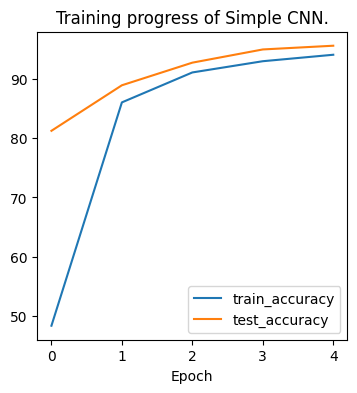

In [39]:
def plot_train_progress(df, title):
    plt.figure(figsize=(4,4))
    plt.title(f"Training progress of {title}.")
    plt.plot(df["train_accuracy"], label="train_accuracy")
    plt.plot(df["test_accuracy"], label="test_accuracy")
    plt.xlabel("Epoch")
    plt.legend()

plot_train_progress(result, "Simple CNN")

In [28]:
data = pd.DataFrame(result["alphas"])
torch.tensor([arr.detach().cpu().numpy() for arr in data["conv1 alpha"]])

<ipython-input-28-693e07090895>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  torch.tensor([arr.detach().cpu().numpy() for arr in data["conv1 alpha"]])


tensor([[-1.0521,  1.6835,  0.3068],
        [-1.0521,  1.6835,  0.3068],
        [-1.0521,  1.6835,  0.3068],
        [-1.0521,  1.6835,  0.3068],
        [-1.0521,  1.6835,  0.3068]])

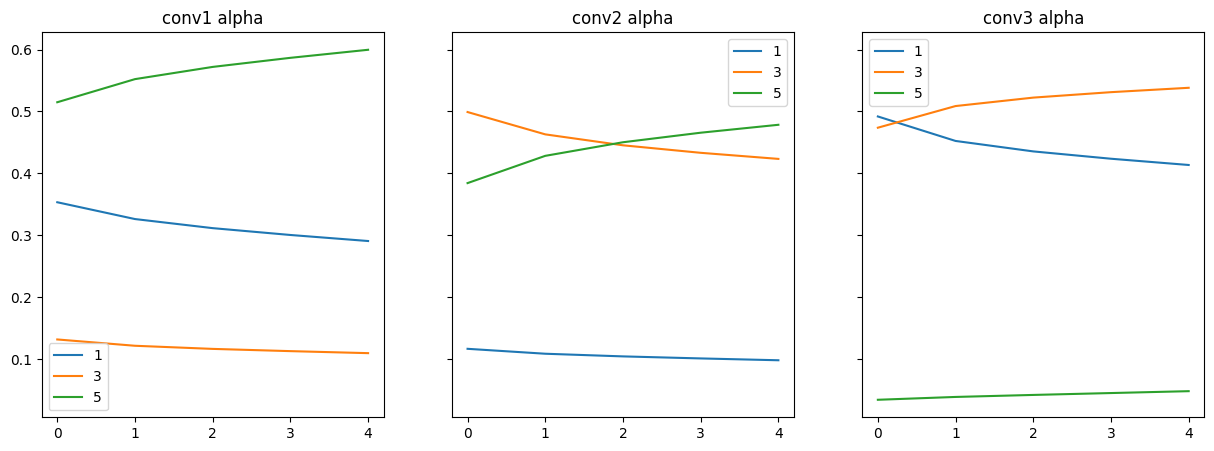

In [40]:
def show_param_numbers(result):
    data = pd.DataFrame(result["alphas"])
    f, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
    for i, conv in enumerate(data):
        alphas = torch.tensor([arr for arr in data[conv]])
        ax[i].set_title(conv)
        ax[i].plot(torch.softmax(alphas, dim=-1), label=[1, 3, 5])
        ax[i].legend()

show_param_numbers(result)

## Энтропийная регуляризация

Мы видим что альфы не сильно отходят от своих изначальных значений, попробуем другую инициализацию

# Эволюционный алгоритм


Сделаем искуственный датасет $\tanh(ReLU(x)^2) $. И попробуем найти под него модель

In [41]:
class SimpleFunctionDataset(torch.utils.data.Dataset):
    def __init__(self, size=10000):
        """
        Args:
            size (int): Number of samples in the dataset.
            features_dim (int): Dimension of the feature vector.
        """
        self.size = size
        self.features_dim = 1
        self.features = torch.randn(size, self.features_dim)

        self.targets = torch.relu(self.features)
        self.targets = self.targets ** 2
        self.targets = torch.tanh(self.targets)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        sample = self.features[idx], self.targets[idx]
        return sample


class Square(nn.Module):
    def forward(self, x):
        return x ** 2

class OpLayer(nn.Module):
    def __init__(self):
        super(OpLayer, self).__init__()
        self.ops = nn.ModuleList([
            torch.nn.Tanh(),
            torch.nn.ReLU(),
            Square(),
        ])
        self.alphas = nn.Parameter(torch.tensor([1., 0., 0.]))

    def forward(self, x, target_mode=False):
        if target_mode:
            return self.ops[torch.argmax(self.alphas, dim=-1)](x)
        return sum(F.softmax(self.alphas, dim=-1)[i] * op(x) for i, op in enumerate(self.ops))

class EvoSupernet(nn.Module):
    def __init__(self):
        super(EvoSupernet, self).__init__()
        self.op1 = OpLayer()
        self.op2 = OpLayer()
        self.op3 = OpLayer()

    def forward(self, x, target_mode=False):
        x = self.op1(x, target_mode)
        x = self.op2(x, target_mode)
        x = self.op3(x, target_mode)
        return x

    def get_alphas(self):
        res = {}
        for name, module in self.named_modules():
            if isinstance(module, OpLayer):
                res[f"{name}.alphas"] = module.alphas
        return res

In [65]:
def mutate_alphas(alphas, mutation_rate=0.1):
    """Mutate alphas by adding Gaussian noise."""
    if torch.randn((1,)) > 0:
        alphas = torch.zeros_like(alphas)
        alphas[torch.randint(0, 3, (1,))] = 1
    return alphas

def random_init(alphas):
    alphas = torch.zeros_like(alphas)
    alphas[torch.randint(0, 3, (1,))] = 1
    return alphas

def evolutionary_search(model, dataset, generations=20, population_size=10, mutation_rate=0.1, die_old=True):
    """Simple evolutionary search on the alphas parameters."""
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
    best_alphas = {name: param for name, param in model.get_alphas().items()}
    best_loss = float('inf')

    population = []
    for _ in range(population_size):
        alphas = {name: random_init(param) for name, param in model.get_alphas().items()}
        for name, param in model.named_parameters():
            if name in alphas:
                param.data.copy_(alphas[name])
        loss = evaluate_model(model, dataloader)
        population += [(alphas, loss)]

    for generation in range(generations):
        sample = [population[i] for i in np.random.choice(len(population), 5, replace=False)]
        parent_alpha, parent_loss = min(sample, key=lambda x: x[1])
        mutated_alphas = {name: mutate_alphas(param, mutation_rate) for name, param in parent_alpha.items()}
        for name, param in model.named_parameters():
            if name in mutated_alphas:
                param.data.copy_(mutated_alphas[name])
        loss = evaluate_model(model, dataloader)
        population += [(mutated_alphas, loss)]

        if die_old:
            population = population[1:]
        else:
            worst_index = max(zip(population, range(len(population))), key=lambda x: x[0][1])[1]
            population = [(a, v) for n, (a, v) in enumerate(population) if n != worst_index]

        best_alphas, best_loss = min(population, key=lambda x: x[1])
        print(f"Generation {generation}, Best Loss: {best_loss}")

    # Apply the best alphas to the model
    for name, param in model.named_parameters():
        if name in best_alphas:
            param.data.copy_(best_alphas[name])
    print(best_alphas)

def evaluate_model(model, dataloader):
    """Evaluate the model on the dataset and return the loss."""
    model.eval()
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs, target_mode=True)
            loss = F.mse_loss(outputs, targets)
    return loss.item()

# Example usage
dataset = SimpleFunctionDataset()
model = EvoSupernet()
evolutionary_search(model, dataset, die_old=True)

Generation 0, Best Loss: 0.00918967928737402
Generation 1, Best Loss: 0.005843508057296276
Generation 2, Best Loss: 0.005843508057296276
Generation 3, Best Loss: 0.005843508057296276
Generation 4, Best Loss: 0.005843508057296276
Generation 5, Best Loss: 0.005843508057296276
Generation 6, Best Loss: 0.005843508057296276
Generation 7, Best Loss: 0.005843508057296276
Generation 8, Best Loss: 0.005843508057296276
Generation 9, Best Loss: 0.005843508057296276
Generation 10, Best Loss: 0.005843508057296276
Generation 11, Best Loss: 0.00918967928737402
Generation 12, Best Loss: 0.00918967928737402
Generation 13, Best Loss: 0.00918967928737402
Generation 14, Best Loss: 0.00918967928737402
Generation 15, Best Loss: 0.0
Generation 16, Best Loss: 0.0
Generation 17, Best Loss: 0.0
Generation 18, Best Loss: 0.0
Generation 19, Best Loss: 0.0
{'op1.alphas': tensor([0., 1., 0.]), 'op2.alphas': tensor([0., 0., 1.]), 'op3.alphas': tensor([1., 0., 0.])}
